In [1]:
"""
An implementation of Fully Connected Autoencoder architecture for dimensionality
reduction for bearing fault pattern dimensionality reduction,
for Fault Detection and Identification Course, KNTU, Spring 2023.

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2023-05-20: Initial coding
"""

In [ ]:
# Imports
import torch
import torch.nn.functional as F                          # Parameterless functions, like activation functions
from torch import optim                                  # For optimizers like SGD, Adam, etc.
from torch import nn                                     # neural network modules
from torch.utils.data import Dataset, DataLoader         # dataset managment by creating mini batches etc.
from tqdm import tqdm                                    # For nice progress bar!
import matplotlib.pyplot as plt                          # for plotting!
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sn

## Reading data in .csv format using pandas

In [ ]:
x = np.array(pd.read_csv('/content/drive/MyDrive/bearingFaultData.csv'))
print(x.shape)

(959, 12)


## t-sne for visualization

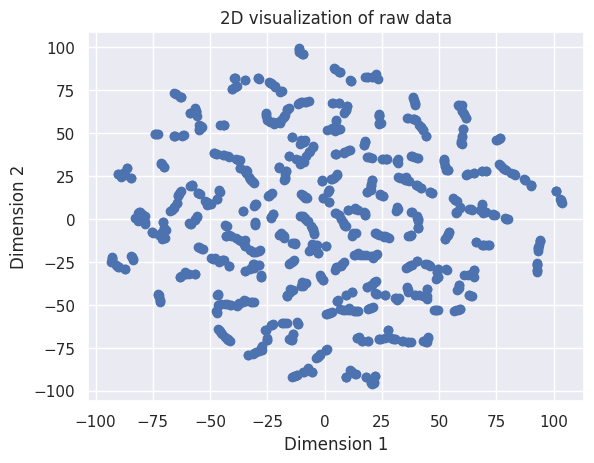

In [ ]:
sn.set_theme(style="darkgrid")
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(x)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.title('2D visualization of raw data')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## Investigating data before normalization

In [ ]:
print(x.min())
print(x.max())

-3806.1
3713700.0


## Normalizing data

In [ ]:
x_min = np.amin(x, axis=0)
x_max = np.amax(x, axis=0)

normalized_x = (x - x_min)/(x_max - x_min)

In [ ]:
print(normalized_x.min())
print(normalized_x.max())

0.0
1.0


## Defining custome dataset class

In [ ]:
class AEDataset(Dataset):
    def __init__(self, x):
        self.x = torch.from_numpy(x).to(torch.float32)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

# Just for test
ds = AEDataset(normalized_x)
print(len(ds))
print(ds[0])

959
tensor([3.4343e-01, 2.4537e-02, 4.6557e-01, 2.4537e-02, 9.3741e-04, 3.0720e-01,
        4.7025e-05, 2.7687e-02, 5.8099e-01, 9.6940e-01, 2.5042e-02, 0.0000e+00])


In [ ]:
batch_size = 64
dataset = AEDataset(normalized_x)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [ ]:
# dataiter = iter(data_loader)
# features = next(dataiter)
# print(torch.min(features), torch.max(features))
# print(features.shape)

## Defining autoencoder model

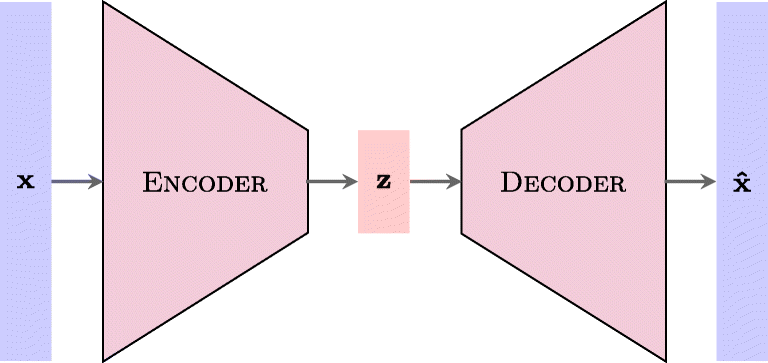

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Error histogram before training

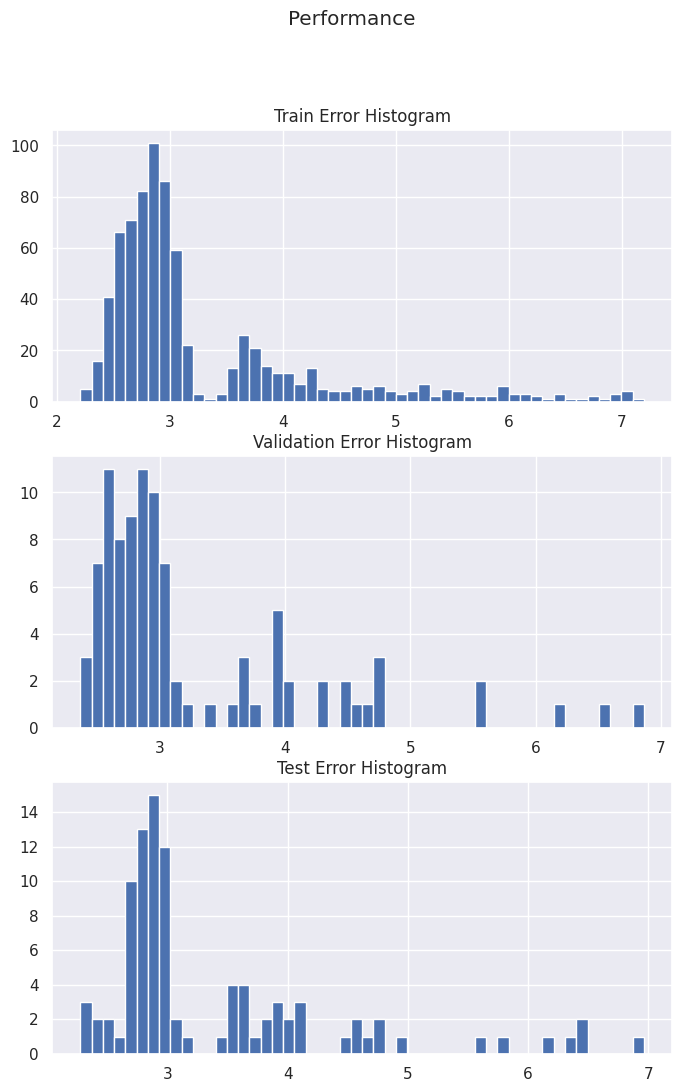

In [ ]:
train_samples = torch.zeros(len(train_set), 12)
validation_samples = torch.zeros(len(validation_set), 12)
test_samples = torch.zeros(len(test_set), 12)

train_recon = torch.zeros(len(train_set), 12)
validation_recon = torch.zeros(len(validation_set), 12)
test_recon = torch.zeros(len(test_set), 12)

model.eval()
with torch.no_grad():
  # Getting reconstructed signals for train set
  pointer = 0
  for batch in train_loader:
      train_samples[pointer:pointer+batch.shape[0]] = batch
      train_recon[pointer:pointer+batch.shape[0]] = model(batch)[1]
      pointer+=batch.shape[0]
  # Getting reconstructed signals for validation set
  pointer = 0
  for batch in validation_loader:
      validation_samples[pointer:pointer+batch.shape[0]] = batch
      validation_recon[pointer:pointer+batch.shape[0]] = model(batch)[1]
      pointer+=batch.shape[0]
  # Getting reconstructed signals for test set
  pointer = 0
  for batch in test_loader:
      test_samples[pointer:pointer+batch.shape[0]] = batch
      test_recon[pointer:pointer+batch.shape[0]] = model(batch)[1]
      pointer+=batch.shape[0]
model.train()

train_error = torch.sum((train_samples - train_recon)**2, 1)
validation_error = torch.sum((validation_samples - validation_recon)**2, 1)
test_error = torch.sum((test_samples - test_recon)**2, 1)

plt.figure(figsize=(8, 12))
#plot 1:
plt.subplot(3, 1, 1)
plt.hist(train_error, 50)
plt.title('Train Error Histogram')
#plot 2:
plt.subplot(3, 1, 2)
plt.hist(validation_error, 50)
plt.title('Validation Error Histogram')
#plot 3:
plt.subplot(3, 1, 3)
plt.hist(test_error, 50)
plt.title('Test Error Histogram')
plt.suptitle("Performance")
plt.show()

## Trainer Function and other useful function during training procedure

In [ ]:
def get_info(model, loader):
  batch_loss = []
  epoch_loss = []
  model.eval()
  with torch.no_grad():
    for data in loader:
      # Get data to device
      data = data.to(device=device)
      # Forward
      _, recon = model(data)
      loss = criterion(recon, data)
      # Taking record of losses
      batch_loss.append(loss.item())
  model.train()
  return sum(batch_loss)/len(batch_loss)

In [ ]:
# Train Network
def Train(model, device, criterion, optimizer, num_epochs):
  train_loss = []
  validation_loss = []
  for epoch in range(num_epochs):
      for batch_idx, (data) in enumerate(tqdm(train_loader)):
          # Get data to device
          data = data.to(device=device)
          # Forward
          _, recon = model(data)
          loss = criterion(recon, data)
          # Backward
          optimizer.zero_grad()
          loss.backward()

          # Gradient descent or adam step
          optimizer.step()

      # Taking record of losses
      tr_loss = get_info(model, train_loader)
      val_loss = get_info(model, validation_loader)
      train_loss.append(tr_loss)
      validation_loss.append(val_loss)

  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title("Performance/Loss")
  plt.legend(['Train Loss', 'Validation Loss'])
  plt.show()

100%|██████████| 12/12 [00:00<00:00, 675.00it/s]


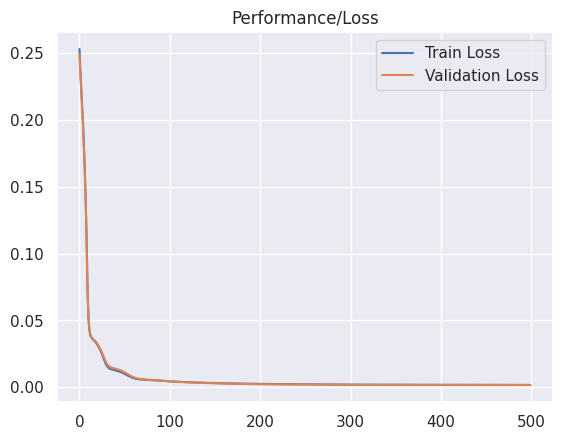

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 500
Train(model, device, criterion, optimizer, num_epochs)

### Post-train error histogram

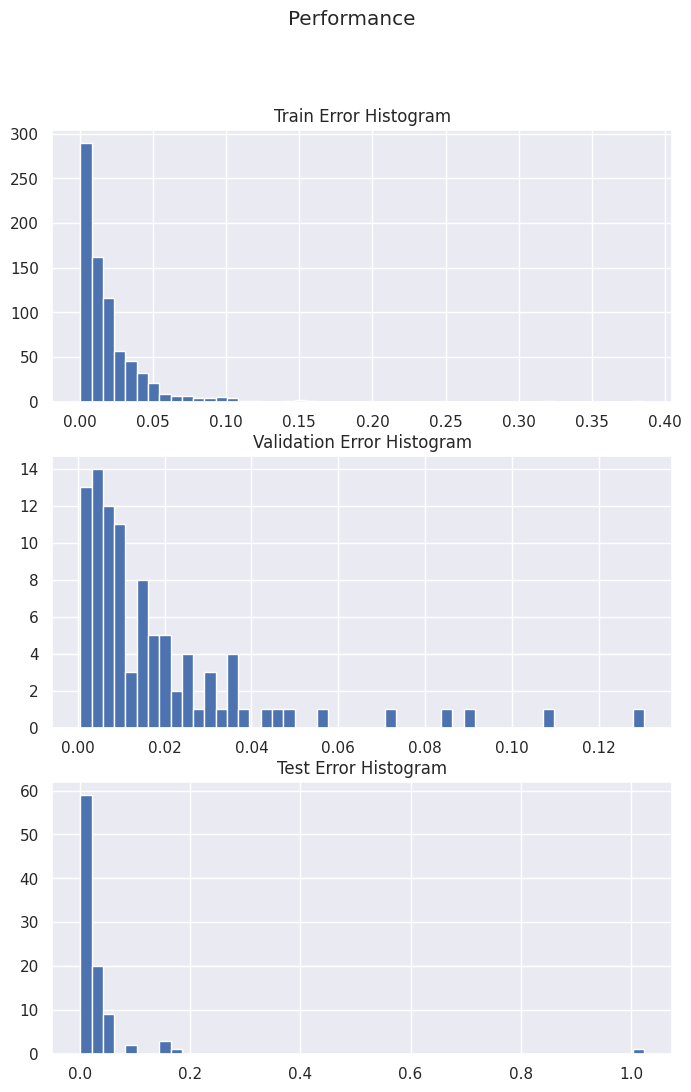

In [ ]:
train_samples = torch.zeros(len(train_set), 12)
validation_samples = torch.zeros(len(validation_set), 12)
test_samples = torch.zeros(len(test_set), 12)

train_recon = torch.zeros(len(train_set), 12)
validation_recon = torch.zeros(len(validation_set), 12)
test_recon = torch.zeros(len(test_set), 12)

model.eval()
with torch.no_grad():
  # Getting reconstructed signals for train set
  pointer = 0
  for batch in train_loader:
      train_samples[pointer:pointer+batch.shape[0]] = batch
      train_recon[pointer:pointer+batch.shape[0]] = model(batch)[1]
      pointer+=batch.shape[0]
  # Getting reconstructed signals for validation set
  pointer = 0
  for batch in validation_loader:
      validation_samples[pointer:pointer+batch.shape[0]] = batch
      validation_recon[pointer:pointer+batch.shape[0]] = model(batch)[1]
      pointer+=batch.shape[0]
  # Getting reconstructed signals for test set
  pointer = 0
  for batch in test_loader:
      test_samples[pointer:pointer+batch.shape[0]] = batch
      test_recon[pointer:pointer+batch.shape[0]] = model(batch)[1]
      pointer+=batch.shape[0]
model.train()

train_error = torch.sum((train_samples - train_recon)**2, 1)
validation_error = torch.sum((validation_samples - validation_recon)**2, 1)
test_error = torch.sum((test_samples - test_recon)**2, 1)

plt.figure(figsize=(8, 12))
#plot 1:
plt.subplot(3, 1, 1)
plt.hist(train_error, 50)
plt.title('Train Error Histogram')
#plot 2:
plt.subplot(3, 1, 2)
plt.hist(validation_error, 50)
plt.title('Validation Error Histogram')
#plot 3:
plt.subplot(3, 1, 3)
plt.hist(test_error, 50)
plt.title('Test Error Histogram')
plt.suptitle("Performance")
plt.show()

## Getting the latent representation of the data for training a classifier

In [ ]:
train_code = torch.zeros(len(train_set), 4)
validation_code = torch.zeros(len(validation_set), 4)
test_code = torch.zeros(len(test_set), 4)

model.eval()
with torch.no_grad():
  # Getting train set latent representation
  pointer = 0
  for batch in train_loader:
      train_code[pointer:pointer+batch.shape[0]] = model(batch)[0]
      pointer+=batch.shape[0]
  # Getting validation set latent representation
  pointer = 0
  for batch in validation_loader:
      validation_code[pointer:pointer+batch.shape[0]] = model(batch)[0]
      pointer+=batch.shape[0]
  # Getting test set latent representation
  pointer = 0
  for batch in test_loader:
      test_code[pointer:pointer+batch.shape[0]] = model(batch)[0]
      pointer+=batch.shape[0]
model.train()

print(train_code.shape)
print(validation_code.shape)
print(test_code.shape)

torch.Size([768, 4])
torch.Size([96, 4])
torch.Size([95, 4])
